# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
Hideyuki SAKONO

## Table of contents  
[Introduction and Business Problem](#introduction)  
[Data](#data)  
[Methodology](#methodology)  
[Analysis](#analysis)  
[Results and Discussion](#results)  
[Conclusion](#conclusion)

## Introduction and Business Problem<a name="\introduction\"></a>
The decision making on opening a new restaurant is always difficult problem for an individual owner or a company.  
Usually, deciding the location of the new restaurant or shop involves intensive data analysis not only on the location but also other aspects, such as the size of existing shops, demographic and transportation aspects of the surrounding area of the potential target location.   
However, in its early stage of the decision making process, a quick and basic graphical representation of data would give the stakeholders useful intuitions on the feasibility of opening-up a new restaurant.  
It is natural to assume that the location of restaurants differs depending on the types of restaurants. In addition to the difference between fine and casual dining restaurant, difference in ethnic restaurants is necessary to be considered. In this process, the locations of ethnic enclaves in Toronto need to be considered. For example, there should be many Chinese restaurants in Chinatown and may be relatively large number of Japanese restaurants in Little Tokyo area.
In this assignment, simple spatial distributions of several types of restaurant in Toronto downtown area will be shown based on the data from Foursquare and the difference will be discussed according to the type. 
Then, based on the basic comparison, one type of restaurant, for example Italian restaurant, will be focused and the possible strategy for the location of a new shop based on the data. 

## Data<a name="\data\"></a>
For comparing several types of restaurants’ locational data, three types of restaurants located in the same area will be searched, which will be Chinese, Italian, and Japanese. The target area will be the downtown area of Toronto, which will be circular area with radius of 2000 meters from the point of “Toronto, ON” generated by geolocator (43.6534817, -79.3839347) in this assignment.

In [4]:
!pip install geopy folium scipy
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from scipy.spatial import Voronoi, voronoi_plot_2d

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
Libraries imported.


In [5]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


This report focuses on downtown Toronto and several types of ethnic restaurants and target areas of this report will be discussed. There are two restrictions for the analysis in this report. One is the size of areas defined by radius from its center point and another is the numbers of venues within that area extracted via Foursquare API, which is 100 for free user.
By looking at downtown area of Toronto considering ethnic enclaves, Chinese and Japanese restaurants’ location of in this area may be affected because many ethnic restaurants tend to be densely located in these areas

In [13]:
CLIENT_ID = 'MIGLPULSS4IWLZ25BAOH3GKBYQ5JHW4Y110G25JME3LDGMP0' # your Foursquare ID
CLIENT_SECRET = 'D0YTIBRKNXDTUEPOECR20D5YH4F0AMRRUOUVOP5ZUGGV52C2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200
# LIMIT will be reset to 100, though...
radius = 2000 # define radius

In [14]:
# For extracting a certain kind of restaurant, categoryId is specified and sent to Foursqure server.
# This is for Cheinse restaurants.

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d145941735'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MIGLPULSS4IWLZ25BAOH3GKBYQ5JHW4Y110G25JME3LDGMP0&client_secret=D0YTIBRKNXDTUEPOECR20D5YH4F0AMRRUOUVOP5ZUGGV52C2&v=20180605&ll=43.6534817,-79.3839347&radius=2000&limit=200&categoryId=4bf58dd8d48988d145941735'

In [15]:
results = requests.get(url).json()

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,GB Hand-Pulled Noodles,Chinese Restaurant,43.656434,-79.383783
1,Yueh Tung Chinese Restaurant,Chinese Restaurant,43.655281,-79.385337
2,Xam Yu,Chinese Restaurant,43.655108,-79.398882
3,Modern Wok,Chinese Restaurant,43.647339,-79.384351
4,Lee,Chinese Restaurant,43.644375,-79.400425


In [18]:
nearby_venues.shape

(100, 4)

In [32]:

map_toronto_chinese = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_chinese)
map_toronto_chinese

In [20]:
# Second time is Japanese restaurants
url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d111941735'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url2 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MIGLPULSS4IWLZ25BAOH3GKBYQ5JHW4Y110G25JME3LDGMP0&client_secret=D0YTIBRKNXDTUEPOECR20D5YH4F0AMRRUOUVOP5ZUGGV52C2&v=20180605&ll=43.6534817,-79.3839347&radius=2000&limit=200&categoryId=4bf58dd8d48988d111941735'

In [21]:
results = requests.get(url2).json()

In [23]:
# create map of Manhattan using latitude and longitude values
map_toronto_japanese = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_japanese)
map_toronto_japanese

In [24]:
nearby_venues.shape

(100, 4)

In [26]:
# The third one is Italian Restaurants.

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d110941735'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url3 # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MIGLPULSS4IWLZ25BAOH3GKBYQ5JHW4Y110G25JME3LDGMP0&client_secret=D0YTIBRKNXDTUEPOECR20D5YH4F0AMRRUOUVOP5ZUGGV52C2&v=20180605&ll=43.6534817,-79.3839347&radius=2000&limit=200&categoryId=4bf58dd8d48988d110941735'

In [27]:
results = requests.get(url3).json()


In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Mirto,Italian Restaurant,43.650702,-79.376307
1,Carisma,Italian Restaurant,43.649617,-79.375434
2,Mangia and Bevi Resto-Bar,Italian Restaurant,43.652250,-79.366355
3,Gusto 101,Italian Restaurant,43.644988,-79.400270
4,Tutti Matti,Italian Restaurant,43.647156,-79.393905


In [29]:
nearby_venues.shape

(100, 4)

In [30]:
# create map of Manhattan using latitude and longitude values
map_toronto_italian = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='greenyellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_italian)
map_toronto_italian

### By looking at downtown area of Toronto considering ethnic enclaves, Chinese and Japanese restaurants’ location of in this area may be affected because many ethnic restaurants tend to be densely located in these areas

### Checking the number of venues within a certain number of radis can be done by changing the number of radius . 

## Methodology<a name="\methodology\"></a>
Two dimensional Voronoi diagram will be used for illustrates theoretical trade area of each shop for the purpose of discussing the possible location of a new site. This analysis will be conducted by using the locational data of Italian restaurants.

In [33]:
# This list is extracted actual Foresquare data
# Looking at only a small part of the target area.

sample_list=[
['Fusaro\'s',43.653347,-79.369517],
['Ardo',43.651201,-79.368350],
['Mangia and Bevi Resto-Bar',43.652250,-79.366355],
['Cafe Oro di Napoli',43.651234,-79.372058],
['Basso',43.655532,-79.365071],
['Bellisimo Pizzeria & Ristorante',43.648748,-79.368684],
['B Espresso Bar',43.653445,-79.374705],
['Biagio Ristorante',43.650411,-79.372425]
]
sample_df=pd.DataFrame(sample_list)
sample_df.columns=['name','lat','lng']
sample_df

,name,lat,lng
0,Fusaro's,43.653347,-79.369517
1,Ardo,43.651201,-79.368350
2,Mangia and Bevi Resto-Bar,43.652250,-79.366355
3,Cafe Oro di Napoli,43.651234,-79.372058
4,Basso,43.655532,-79.365071
5,Bellisimo Pizzeria & Ristorante,43.648748,-79.368684
6,B Espresso Bar,43.653445,-79.374705
7,Biagio Ristorante,43.650411,-79.372425


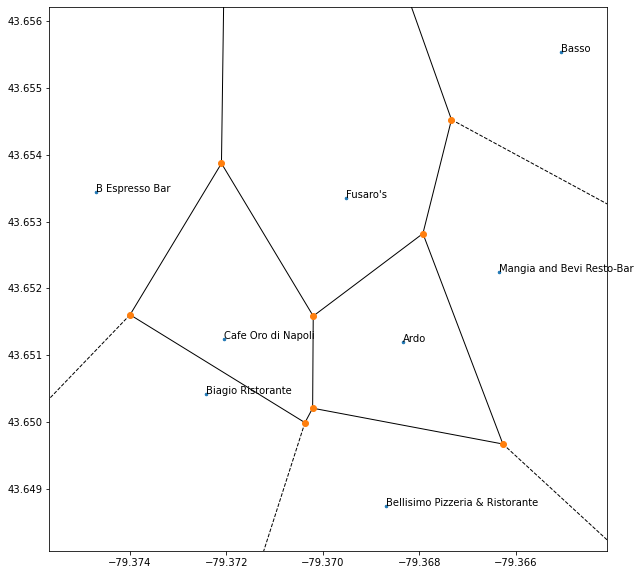

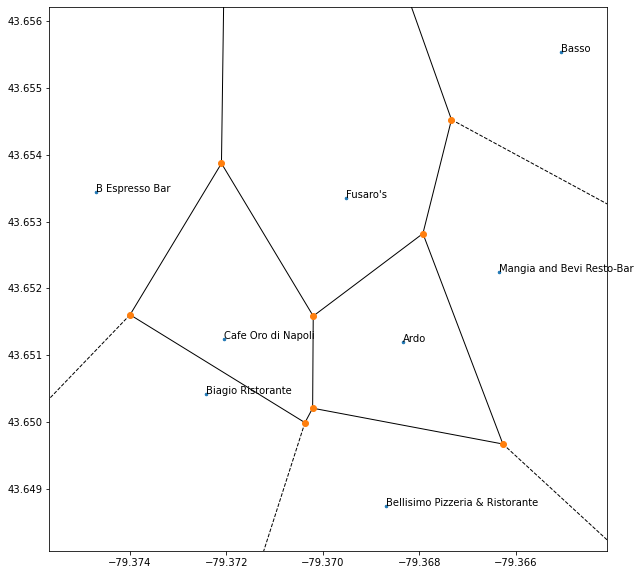

In [34]:
vor_sample = Voronoi(sample_df.loc[:,['lng','lat']])
fig2, ax2 = plt.subplots(figsize=(10,10))

shop_names = sample_df[["name"]].values.flatten() 
shop_x = sample_df['lng']
shop_y = sample_df['lat']
for i, name in enumerate(shop_names):
    ax2.annotate(name, (shop_x[i], shop_y[i]))
    
voronoi_plot_2d(vor_sample, ax2, show_vertices=True, point_size=5)

In [35]:
#This is the list of orange points above.
vor_sample.vertices

array([[-79.37191372,  43.66383963],
       [-79.36733661,  43.6545262 ],
       [-79.37037245,  43.64998903],
       [-79.37210202,  43.65387129],
       [-79.37399535,  43.6516046 ],
       [-79.366271  ,  43.64966868],
       [-79.36792833,  43.65282062],
       [-79.37021301,  43.65020543],
       [-79.37020073,  43.65158488]])

In [37]:
# create map of a small part of target area
# In the full report, Volonoi diagram and map was combined by using external software but verticies can be plot in the same map.
map_toronto_italian_sample = folium.Map(location=[latitude, longitude], zoom_start=16)

# add markers to map
for lat, lng, label in zip(sample_df['lat'], sample_df['lng'], sample_df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='greenyellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_italian_sample)

for lat, lng in zip(vor_sample.vertices[:,1], vor_sample.vertices[:,0]):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.7).add_to(map_toronto_italian_sample)
map_toronto_italian_sample


## Results<a name="\results\"></a>
Based on the preparation above, all data in the target area of this report will be analyzed. 

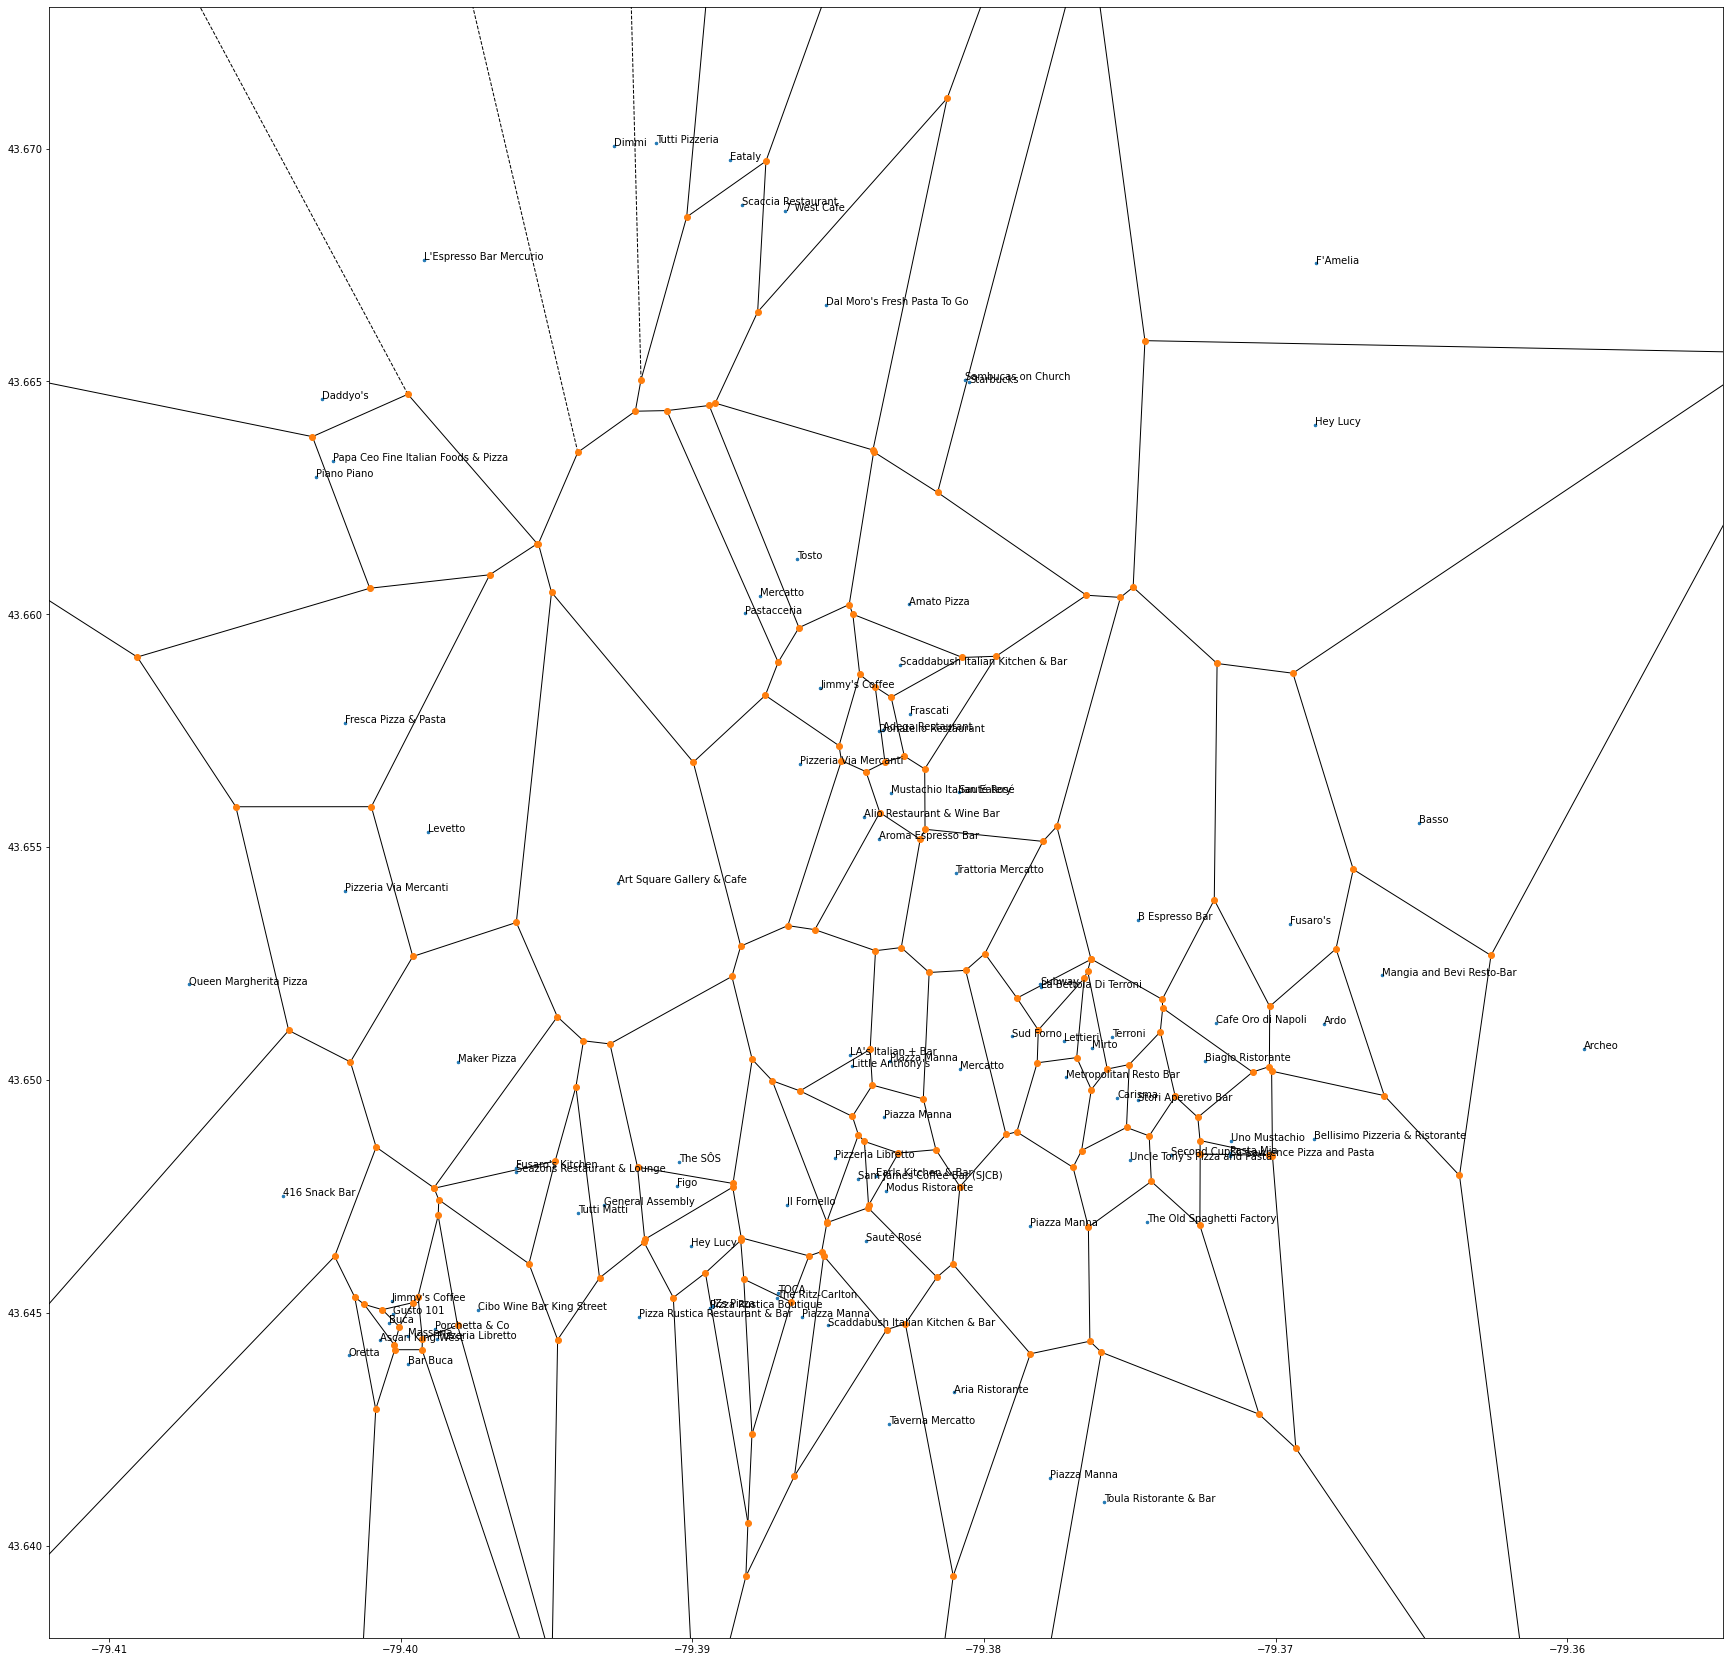

In [39]:
vor = Voronoi(nearby_venues.loc[:,['lng','lat']])
vor.vertices


fig, ax = plt.subplots(figsize=(30,30))

shop_names = nearby_venues[["name"]].values.flatten() 
shop_x = nearby_venues['lng']
shop_y = nearby_venues['lat']
for i, name in enumerate(shop_names):
    ax.annotate(name, (shop_x[i], shop_y[i]))
    
voronoi_plot_2d(vor, ax, show_vertices=True, point_size=5)

fig.savefig('volonoi_all.png')

## Discussion<a name="\discussion\"></a>
Even though a precise evaluation needs the distance from each vertex to its corresponding sites, several examples with the large-enough distance will be discussed in the following section. It is because, even if we pick up a vertex with the largest distance to its corresponding restaurants, the point can be physically unable to open a new site. 

### Please refer to the figures in my full report.
The area around University of Toronto St. George Campus seems to be attractive with several vertices with reasonably distant from surrounding Italian restaurants; however, all of these locations have problems for opening a new restaurant because these are either surrounded by campus buildings or the middle of a spaces owned by the university. It would be difficult to go on to the intense discussion for opening a new site.

Another possible area based on the diagram would be the area close to Allan Gardens. Even though there are not so many other types of shops in the area, which means there may not be enough customer walking around the area, it would be one possible area that the decision maker can go on to thorough examination of other economic aspects of surrounding areas.

Discussion on Assumptions
This analysis by using Volonoi diagram is based on very strong assumptions. In reality, customers will not necessarily visit their closest Italian restaurant; thus, the trade area of a restaurants cannot be shown as a simple polygon. 

Another strong underlying assumption is that the quality of all restaurants is the same, in other words, based on this strong hypothesis, the condition that a customer goes to one’s nearest shop can hold. But in reality, for example, a Chinese restaurants with moderate quality will not survive in the middle of China town where severe competition would occur among best Chinese restaurants in Toronto. Furthermore, the actual data derived from Foursquare contains various types of shops and restaurants, such as pizza shops and Italian café.

## Conclusion<a name="\conclusion\"></a>
This report extracted several types of ethnic restaurants in Toronto downtown area and focused on Italian restaurants for opening a new restaurants in the target area by utilizing the result of Volonoi diagram. Even though the analysis is based on strong assumptions; the result could give a business owner or a company to start discussing the strategy for opening a new site. It is very important to evaluate the possible location and its surrounding area and the thorough investigation on various aspects other than a simple geographical location of other competitors in the target area.